In [342]:
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr, spearmanr
import seaborn as sns
import matplotlib.pyplot as plt

# Helper Functions

In [343]:
def merge_text_hume_data(df_facial, df_text):

    df_text_merged = df_text.groupby('start_patch')['text_anger', 'text_disgust', 'text_fear', 'text_joy', 'text_sadness', 'text_surprise', 'text_neutral'].mean().reset_index()
    df_facial_merged = df_facial.groupby('start_patch')['facial_anger', 'facial_disgust', 'facial_fear', 'facial_joy', 'facial_sadness', 'facial_surprise', 'facial_neutral'].mean().reset_index()
    df_merged = pd.merge(df_text_merged, df_facial_merged, on=['start_patch'], how='inner').drop('start_patch', axis=1)
    return df_merged

In [344]:
def prepare_text_data(path):
    df_text = pd.read_csv(path, index_col=0)
    df_text['start'] = np.floor(((df_text['start']/60)/5))*5
    df_text.drop(['end', 'segment_id'], axis=1, inplace=True)
    df_text.columns = ['start_patch', 'text_anger', 'text_disgust', 'text_fear', 'text_joy', 'text_sadness', 'text_surprise', 'text_neutral']
    return df_text

In [345]:
def prepare_hume_data(path):
    df_facial = pd.read_csv(path, index_col=0)
    df_facial.drop('start', axis=1, inplace=True)
    df_facial.columns = ['facial_anger', 'facial_disgust', 'facial_fear', 'facial_joy', 'facial_sadness', 'facial_surprise', 'facial_neutral', 'start_patch']
    return df_facial
    

In [346]:
def create_merged_binary_emotion_data(df_merged):
    df_binary=pd.DataFrame(df_merged[['facial_anger', 'facial_disgust','facial_fear', 'facial_sadness']].mean(axis=1), columns=['facial_agg_negative'])
    df_binary['facial_agg_positive'] = df_merged[['facial_neutral', 'facial_surprise','facial_joy']].mean(axis=1)
    df_binary['text_agg_negative'] = df_merged[['text_anger', 'text_disgust','text_fear', 'text_sadness']].mean(axis=1)
    df_binary['text_agg_positive'] = df_merged[['text_neutral', 'text_surprise','text_joy']].mean(axis=1)

    return df_binary

In [347]:
def facial_to_text_interval_merge(df_text, df_facial, interval):
    interval_emotions= [df_facial.loc[(df_facial['start'] >= time) & (df_facial['start'] < (time+interval))].mean(axis=0).drop(['start', 'start_patch']).to_numpy() for time in df_text['start'].to_numpy()]
    df_interval_merge = pd.concat([df_text, pd.DataFrame(interval_emotions, columns=['facial_anger','facial_disgust','facial_fear','facial_joy','facial_sadness','facial_surprise','facial_neutral'])], axis=1)
    return df_interval_merge

In [348]:
def facial_to_text_up_to_next_start_merge(df_facial_in, df_text_in):
    df_text = df_text_in.copy()
    df_facial = df_facial_in.copy()
    df_text['start_next'] = df_text['start'].shift(-1)
    df_text.loc[df_text.index[-1], 'start_next'] = 9999999
    interval_emotions= [df_facial.loc[(df_facial['start'] >= time[0]) & (df_facial['start'] < (time[1]))].mean(axis=0).drop(['start', 'start_patch']).to_numpy() for time in df_text[['start', 'start_next']].to_numpy()]
    df_interval_merge = pd.concat([df_text, pd.DataFrame(interval_emotions, columns=['facial_anger','facial_disgust','facial_fear','facial_joy','facial_sadness','facial_surprise','facial_neutral'])], axis=1)
    return df_interval_merge

In [349]:
def get_correlations_with_binary(df, binary_feature, continuous_features, corr_func=pointbiserialr):
    df = df.dropna()
    correlation_data = []
    for feature in continuous_features:
        corr, p_value = corr_func(df[feature], df[binary_feature])
        correlation_data.append((feature, corr, p_value))
    
    data = correlation_data
    # Extract feature names, correlations, and p-values
    features = [item[0] for item in data]
    correlations = [item[1] for item in data]
    p_values = [item[2] for item in data]

    # Create a figure and axes
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the correlations as vertical bars
    ax.bar(features, correlations, color='steelblue')

    # Set the y-axis label
    ax.set_ylabel('Correlation')

    # Add horizontal gridlines
    ax.yaxis.grid(True)

    # Set the title
    ax.set_title('Correlation with Binary Variable')

    # Add error bars representing p-values
    ax.errorbar(features, correlations, yerr=np.abs(correlations), fmt='none', color='black', capsize=5, label='p-value')

    # Add p-values and absolute correlation values as text annotations
    for feature, correlation, p_value in zip(features, correlations, p_values):
        ax.text(feature, 0, f'p={p_value:.2f}', ha='center', va='bottom')
        ax.text(feature, correlation, f'{abs(correlation):.2f}', ha='center', va='top')

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45, ha='right')

    # Display the plot
    plt.tight_layout()
    plt.show()
    return data

# Hume/Text correlations

In [350]:
df_facial_vocals_morning = prepare_hume_data('../data/hume/processed/Cuban_vocals_morning.csv')
df_text_vocals_morning = prepare_text_data('../data/emotion_from_transcript/emotion-english-distilroberta-base/jazzaar-20230417-morning-JFLB-Cuban-Vocals-video Philipp.csv')
df_vocals_morning = merge_text_hume_data(df_facial_vocals_morning, df_text_vocals_morning)

df_facial_vocals_afternoon = prepare_hume_data('../data/hume/processed/Cuban_vocals_afternoon.csv')
df_text_vocals_afternoon = prepare_text_data('../data/emotion_from_transcript/emotion-english-distilroberta-base/jazzaar-20230417-afternoon-JFLB-Cuban-Vocals-video Philipp.csv')
df_vocals_afternoon = merge_text_hume_data(df_facial_vocals_afternoon, df_text_vocals_afternoon)

df_vocals = pd.concat([df_vocals_morning, df_vocals_afternoon])


df_facial_band_morning = prepare_hume_data('../data/hume/processed/Funk_band_morning.csv')
df_text_band_morning = prepare_text_data('../data/emotion_from_transcript/emotion-english-distilroberta-base/JFBB_Jazz_Funk_morning_video20230419101818 Luis Cal García.csv')
df_band_morning = merge_text_hume_data(df_facial_band_morning, df_text_band_morning)

df_facial_band_afternoon = prepare_hume_data('../data/hume/processed/Funk_band_afternoon.csv')
df_text_band_afternoon = prepare_text_data('../data/emotion_from_transcript/emotion-english-distilroberta-base/JFBB_Jazz_Funk_afternoon_video20230419143359 Luis Cal García.csv')
df_band_afternoon = merge_text_hume_data(df_facial_band_afternoon, df_text_band_afternoon)

df_facial_rhythm_morning = prepare_hume_data('../data/hume/processed/Funk_rhythm_morning.csv')
df_text_rhythm_morning = prepare_text_data('../data/emotion_from_transcript/emotion-english-distilroberta-base/JFBB_Rhythm_Section_Day1_Morning Thomas.csv')
df_rhythm_morning = merge_text_hume_data(df_facial_rhythm_morning, df_text_rhythm_morning)


df_facial_rhythm_afternoon = prepare_hume_data('../data/hume/processed/Funk_rhythm_afternoon.csv')
df_text_rhythm_afternoon = prepare_text_data('../data/emotion_from_transcript/emotion-english-distilroberta-base/JFBB_Rhythm_Section_Day1_Afternoon Thomas.csv')
df_rhythm_afternoon = merge_text_hume_data(df_facial_rhythm_afternoon, df_text_rhythm_afternoon)

df_merged = pd.concat([pd.concat([df_vocals_morning, df_vocals_afternoon, df_band_morning,df_band_afternoon, df_rhythm_morning, df_rhythm_afternoon])])
df_merged

/tmp/ipykernel_354/2961072716.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_text_merged = df_text.groupby('start_patch')['text_anger', 'text_disgust', 'text_fear', 'text_joy', 'text_sadness', 'text_surprise', 'text_neutral'].mean().reset_index()
/tmp/ipykernel_354/2961072716.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_facial_merged = df_facial.groupby('start_patch')['facial_anger', 'facial_disgust', 'facial_fear', 'facial_joy', 'facial_sadness', 'facial_surprise', 'facial_neutral'].mean().reset_index()
/tmp/ipykernel_354/2961072716.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_text_merged = df_text.groupby('start_patch')['text_anger', 'text_disgust', 'text_fear', 'text_joy', 'text_sadness', 'text_surprise', 'text_neutr

/tmp/ipykernel_354/2961072716.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_text_merged = df_text.groupby('start_patch')['text_anger', 'text_disgust', 'text_fear', 'text_joy', 'text_sadness', 'text_surprise', 'text_neutral'].mean().reset_index()
/tmp/ipykernel_354/2961072716.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_facial_merged = df_facial.groupby('start_patch')['facial_anger', 'facial_disgust', 'facial_fear', 'facial_joy', 'facial_sadness', 'facial_surprise', 'facial_neutral'].mean().reset_index()
/tmp/ipykernel_354/2961072716.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_text_merged = df_text.groupby('start_patch')['text_anger', 'text_disgust', 'text_fear', 'text_joy', 'text_sadness', 'text_surprise', 'text_neutr

,text_anger,text_disgust,text_fear,text_joy,text_sadness,text_surprise,text_neutral,facial_anger,facial_disgust,facial_fear,facial_joy,facial_sadness,facial_surprise,facial_neutral
0,0.090660,0.434807,0.053470,0.005787,0.330907,0.047347,0.037022,0.073753,0.132861,0.165540,0.128168,0.181144,0.103265,0.220051
1,0.027510,0.066978,0.040898,0.139679,0.492031,0.081599,0.151304,0.077141,0.138249,0.166908,0.121519,0.192415,0.098344,0.223063
2,0.031876,0.049549,0.013774,0.007627,0.696987,0.015867,0.184320,0.081929,0.108667,0.144073,0.165099,0.142597,0.108096,0.212238
3,0.012535,0.029529,0.004095,0.213810,0.620026,0.012278,0.107727,0.085003,0.111863,0.150903,0.151444,0.153683,0.110996,0.226161
4,0.133437,0.247245,0.018390,0.006704,0.418028,0.017145,0.159051,0.081190,0.119679,0.144456,0.144174,0.167758,0.100934,0.229378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14,0.019270,0.028949,0.002081,0.800222,0.043145,0.005617,0.100717,0.079784,0.128691,0.139421,0.160648,0.159483,0.103155,0.209745
15,0.146943,0.061233,0.005754,0.095575,0.047915,0.017596,0.624984,0.077967,0.135968,0.167722,0.098974,0.192556,0.104190,0.241798
16,0.059860,0.151449,0.011283,0.003760,0.732994,0.013302,0.027352,0.087814,0.131835,0.163778,0.100304,0.193281,0.102365,0.245101
17,0.013363,0.007951,0.003105,0.028178,0.931419,0.004875,0.011108,0.086033,0.129035,0.156456,0.110610,0.184878,0.101590,0.241574


In [351]:
df_facial_vocals_morning

,facial_anger,facial_disgust,facial_fear,facial_joy,facial_sadness,facial_surprise,facial_neutral,start_patch
0,0.039957,0.114220,0.126544,0.169541,0.137182,0.147788,0.157061,0.0
1,0.037922,0.104910,0.110700,0.190294,0.127883,0.129474,0.150551,0.0
2,0.044073,0.118693,0.129124,0.167583,0.158697,0.130753,0.167633,0.0
3,0.041380,0.134487,0.140038,0.133327,0.198558,0.126955,0.179034,0.0
4,0.047777,0.118812,0.136461,0.141578,0.157510,0.128101,0.191475,0.0
...,...,...,...,...,...,...,...,...
119525,0.066564,0.165001,0.129338,0.157906,0.196070,0.089844,0.211994,160.0
119526,0.047728,0.143472,0.094047,0.257106,0.128997,0.098761,0.148710,160.0
119527,0.064104,0.144483,0.124494,0.160216,0.188909,0.095583,0.197851,160.0
119528,0.064802,0.112709,0.161865,0.105411,0.165901,0.067118,0.224333,155.0


### Calculate correlation

#### Entire DS: Calculate correlation

In [352]:
df_merged_corr = df_merged.corr().drop(['text_anger', 'text_disgust', 'text_fear', 'text_joy', 'text_sadness', 'text_surprise', 'text_neutral'], axis=1)
df_merged_corr = df_merged_corr.drop(['facial_anger', 'facial_disgust', 'facial_fear', 'facial_joy', 'facial_sadness', 'facial_surprise', 'facial_neutral'],axis=0)
df_merged_corr

,facial_anger,facial_disgust,facial_fear,facial_joy,facial_sadness,facial_surprise,facial_neutral
text_anger,0.030647,0.026419,0.045136,-0.027098,0.018482,-0.055694,-0.006446
text_disgust,0.106673,0.130017,0.265498,-0.290598,0.181307,-0.033551,0.244649
text_fear,0.004669,0.188536,0.061006,-0.107147,0.126223,-0.062951,0.097711
text_joy,-0.186174,-0.031401,-0.239399,0.248192,-0.151773,-0.074936,-0.162175
text_sadness,0.040674,-0.058825,-0.033796,0.016694,-0.009734,0.084333,-0.032029
text_surprise,-0.058374,-0.034378,-0.041569,0.044833,-0.030497,0.005930,-0.040825
text_neutral,0.104849,-0.014035,0.146123,-0.104857,0.040406,0.034188,0.081800


#### Vocal Correlation

In [353]:
df_vocals_corr = df_vocals.corr().drop(['text_anger', 'text_disgust', 'text_fear', 'text_joy', 'text_sadness', 'text_surprise', 'text_neutral'], axis=1)
df_vocals_corr = df_vocals_corr.drop(['facial_anger', 'facial_disgust', 'facial_fear', 'facial_joy', 'facial_sadness', 'facial_surprise', 'facial_neutral'],axis=0)
df_vocals_corr

,facial_anger,facial_disgust,facial_fear,facial_joy,facial_sadness,facial_surprise,facial_neutral
text_anger,-0.045881,0.100069,-0.129188,0.098272,0.005739,-0.073311,-0.243678
text_disgust,-0.060899,0.078710,0.221521,-0.107566,0.081444,0.102592,0.013843
text_fear,-0.131205,0.199799,0.058511,-0.135095,0.160991,-0.131304,0.172978
text_joy,-0.133227,0.157973,-0.247056,0.123952,0.028122,-0.224934,-0.147086
text_sadness,0.153306,-0.209870,0.178779,-0.077664,-0.067290,0.146088,0.276008
text_surprise,-0.071458,0.013903,-0.057305,-0.005068,0.015906,0.008264,-0.050281
text_neutral,0.151142,-0.099591,0.148357,-0.060442,-0.044162,0.189357,-0.083180


### Correlation aggregated

In [354]:
df_aggregated = create_merged_binary_emotion_data(df_merged)
df_aggregated_corr = df_aggregated.corr().drop(['text_agg_positive','text_agg_negative'], axis=1)
df_aggregated_corr = df_aggregated_corr.drop(['facial_agg_positive','facial_agg_negative'], axis=0)
df_aggregated_corr

,facial_agg_negative,facial_agg_positive
text_agg_negative,0.139707,-0.095456
text_agg_positive,-0.139707,0.095456


# Binary Sentiment data to facial correlation

In [355]:
df_facial_vocals_morning = pd.read_csv('../data/hume/processed/Cuban_vocals_morning.csv', index_col=0)
df_text_vocals_morning = pd.read_csv('../data/emotion_from_transcript/binary_sentiment/jazzaar-20230417-morning-JFLB-Cuban-Vocals-video Philipp.csv', index_col=0)
df_vocals_morning = facial_to_text_up_to_next_start_merge(df_facial_vocals_morning, df_text_vocals_morning)

df_facial_vocals_afternoon = pd.read_csv('../data/hume/processed/Cuban_vocals_afternoon.csv', index_col=0)
df_text_vocals_afternoon = pd.read_csv('../data/emotion_from_transcript/binary_sentiment/jazzaar-20230417-afternoon-JFLB-Cuban-Vocals-video Philipp.csv', index_col=0)
df_vocals_afternoon = facial_to_text_up_to_next_start_merge(df_facial_vocals_afternoon, df_text_vocals_afternoon)

df_vocals = pd.concat([df_vocals_morning, df_vocals_afternoon])


df_facial_band_morning = pd.read_csv('../data/hume/processed/Funk_band_morning.csv', index_col=0)
df_text_band_morning = pd.read_csv('../data/emotion_from_transcript/binary_sentiment/JFBB_Jazz_Funk_morning_video20230419101818 Luis Cal García.csv', index_col=0)
df_band_morning = facial_to_text_up_to_next_start_merge(df_facial_band_morning, df_text_band_morning)

df_facial_band_afternoon = pd.read_csv('../data/hume/processed/Funk_band_afternoon.csv', index_col=0)
df_text_band_afternoon = pd.read_csv('../data/emotion_from_transcript/binary_sentiment/JFBB_Jazz_Funk_afternoon_video20230419143359 Luis Cal García.csv', index_col=0)
df_band_afternoon = facial_to_text_up_to_next_start_merge(df_facial_band_afternoon, df_text_band_afternoon)

df_facial_rhythm_morning = pd.read_csv('../data/hume/processed/Funk_rhythm_morning.csv', index_col=0)
df_text_rhythm_morning = pd.read_csv('../data/emotion_from_transcript/binary_sentiment/JFBB_Rhythm_Section_Day1_Morning Thomas.csv', index_col=0)
df_rhythm_morning = facial_to_text_up_to_next_start_merge(df_facial_rhythm_morning, df_text_rhythm_morning)


df_facial_rhythm_afternoon = pd.read_csv('../data/hume/processed/Funk_rhythm_afternoon.csv', index_col=0)
df_text_rhythm_afternoon = pd.read_csv('../data/emotion_from_transcript/binary_sentiment/JFBB_Rhythm_Section_Day1_Afternoon Thomas.csv', index_col=0)
df_rhythm_afternoon = facial_to_text_up_to_next_start_merge(df_facial_rhythm_afternoon, df_text_rhythm_afternoon)

df_merged = pd.concat([df_vocals_morning, df_vocals_afternoon, df_band_morning,df_band_afternoon, df_rhythm_morning, df_rhythm_afternoon])
df_merged


,segment_id,start,end,positive,negative,start_next,facial_anger,facial_disgust,facial_fear,facial_joy,facial_sadness,facial_surprise,facial_neutral
0,1,129,153,0,1,259.0,0.070177,0.138348,0.176240,0.112927,0.192925,0.105831,0.229195
1,3,259,284,0,1,312.0,0.075582,0.129852,0.168849,0.123392,0.185497,0.102464,0.222223
2,5,312,325,1,0,411.0,0.079979,0.139029,0.171042,0.118120,0.193752,0.097852,0.215117
3,6,411,440,1,0,620.0,0.077519,0.134715,0.163302,0.125553,0.186854,0.098987,0.227154
4,8,620,631,1,0,1371.0,0.084394,0.111273,0.147933,0.157008,0.149651,0.108417,0.215943
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,40,7493,7558,1,0,7597.0,0.084496,0.126726,0.154587,0.112390,0.184284,0.104009,0.241955
25,43,7597,7609,1,0,7715.0,0.084021,0.130491,0.155330,0.118243,0.184752,0.103016,0.231186
26,44,7715,7727,1,0,7914.0,0.085233,0.133249,0.165771,0.098245,0.191657,0.101080,0.244712
27,45,7914,7933,1,0,8092.0,0.078288,0.126510,0.161326,0.119730,0.178722,0.104973,0.230793


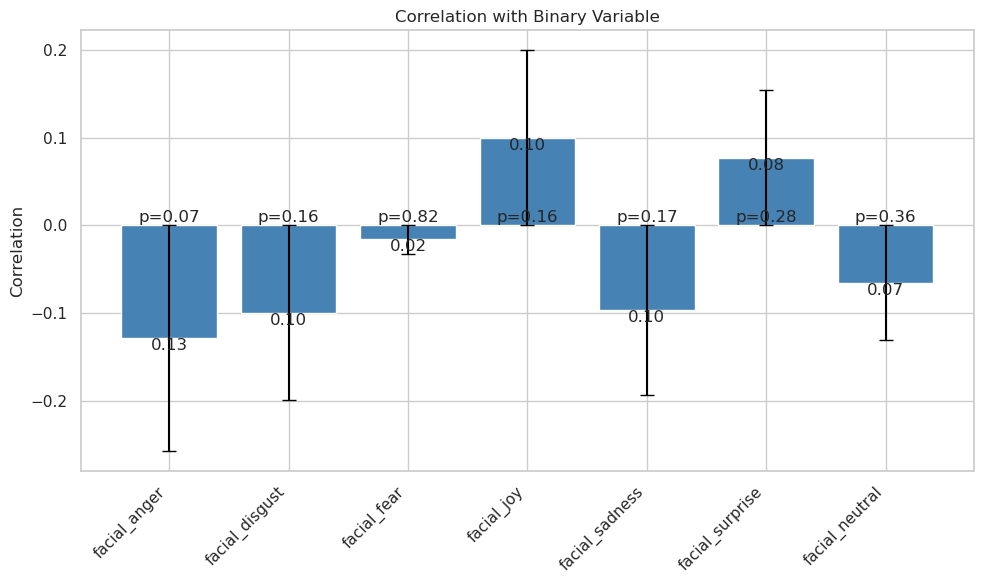

[('facial_anger', -0.12855291983191217, 0.0696543063822405),
 ('facial_disgust', -0.099563949449158, 0.1607036375978743),
 ('facial_fear', -0.016221439641794823, 0.8196595539843482),
 ('facial_joy', 0.0997598456254023, 0.15987778695651206),
 ('facial_sadness', -0.09708783377086296, 0.17141970148565516),
 ('facial_surprise', 0.07716446337234784, 0.27745672203358523),
 ('facial_neutral', -0.065639938645504, 0.355764031804038)]

In [356]:
get_correlations_with_binary(df_merged, 'positive', ['facial_anger','facial_disgust','facial_fear','facial_joy','facial_sadness','facial_surprise','facial_neutral'])

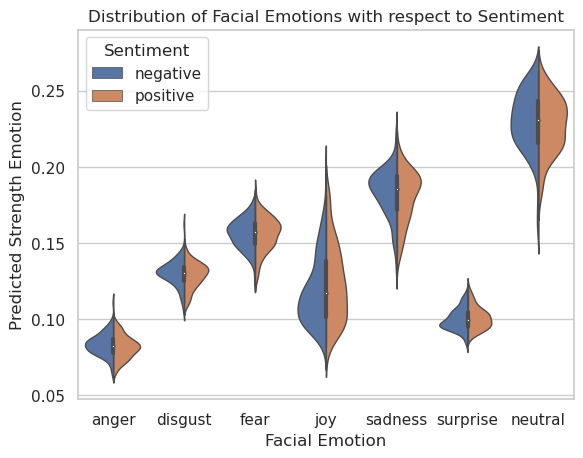

In [357]:
import seaborn as sns

sns.set_theme(style="whitegrid")

# Create a list of facial features
features = ['positive','facial_anger', 'facial_disgust', 'facial_fear', 'facial_joy', 'facial_sadness', 'facial_surprise', 'facial_neutral']
melted = df_merged[features].copy()
melted.columns= ['positive','anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']
melted = pd.melt(melted, id_vars='positive')
melted['positive'] = ['positive' if val == 1 else 'negative' for val in melted['positive']]
# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(data=melted, x="variable", y="value", hue="positive",
               split=True, linewidth=1)

# Set labels and title
plt.xlabel('Facial Emotion')
plt.ylabel('Predicted Strength Emotion')
plt.title('Distribution of Facial Emotions with respect to Sentiment')
plt.legend(title='Sentiment')

# Remove the left spine
# sns.despine(left=True)

# Show the plot
plt.show()

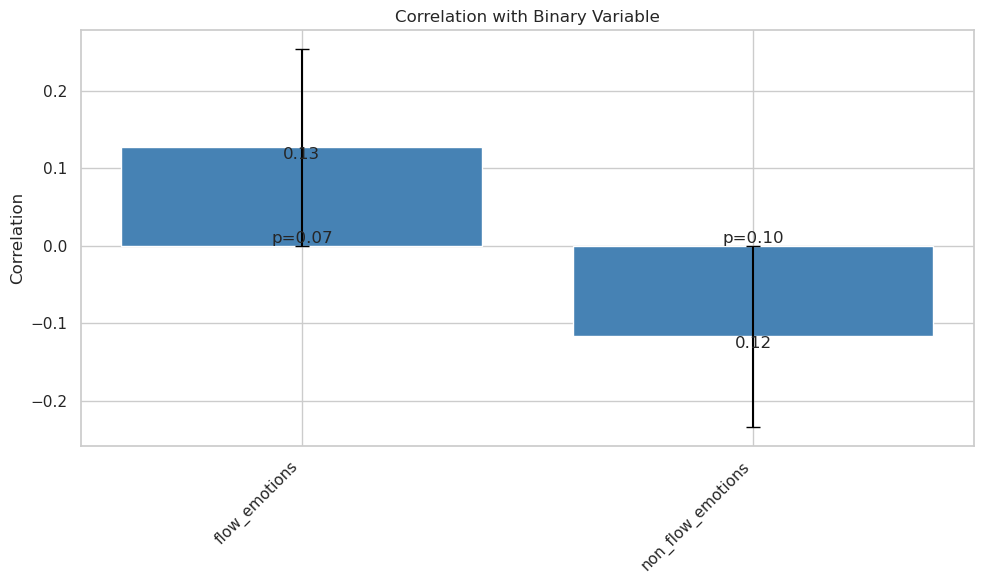

[('flow_emotions', 0.12675803271554975, 0.0736768934675198),
 ('non_flow_emotions', -0.11686384194001564, 0.09935333854415841)]

In [358]:
flow_emotions = ['facial_joy', 'facial_fear', 'facial_surprise']
non_flow =['facial_neutral', 'facial_sadness', 'facial_anger']
df_merged_cleaned = df_merged.drop(['segment_id', 'start', 'end', 'negative'], axis=1)
df_merged_cleaned=df_merged_cleaned.dropna(axis=0)
df_merged_cleaned
df_merged_cleaned['flow_emotions'] = df_merged_cleaned[flow_emotions].mean(axis=1)
df_merged_cleaned['non_flow_emotions'] = df_merged_cleaned[non_flow].mean(axis=1)
get_correlations_with_binary(df_merged_cleaned, 'positive', ['flow_emotions','non_flow_emotions'])

# Correlation emotion to text length

In [359]:
df_facial_vocals_morning = pd.read_csv('../data/hume/processed/Cuban_vocals_morning.csv', index_col=0)
df_text_vocals_morning = pd.read_csv('../data/emotion_from_transcript/binary_sentiment/jazzaar-20230417-morning-JFLB-Cuban-Vocals-video Philipp.csv', index_col=0)
df_vocals_morning = facial_to_text_up_to_next_start_merge(df_facial_vocals_morning, df_text_vocals_morning)
df_vocals_morning_tl = pd.read_csv('../data/transcriptions/transcription_length/jazzaar-20230417-morning-JFLB-Cuban-Vocals-video Philipp.csv', index_col=0)
df_vocals_morning_tl.columns = ['key', 'len']
df_vocals_morning = df_vocals_morning.merge(df_vocals_morning_tl, left_on='segment_id', right_on='key').drop('key', axis=1)

df_facial_vocals_afternoon = pd.read_csv('../data/hume/processed/Cuban_vocals_afternoon.csv', index_col=0)
df_text_vocals_afternoon = pd.read_csv('../data/emotion_from_transcript/binary_sentiment/jazzaar-20230417-afternoon-JFLB-Cuban-Vocals-video Philipp.csv', index_col=0)
df_vocals_afternoon = facial_to_text_up_to_next_start_merge(df_facial_vocals_afternoon, df_text_vocals_afternoon)
df_vocals_afternoon_tl = pd.read_csv('../data/transcriptions/transcription_length/jazzaar-20230417-afternoon-JFLB-Cuban-Vocals-video Philipp.csv', index_col=0)
df_vocals_afternoon_tl.columns = ['key', 'len']
df_vocals_afternoon = df_vocals_afternoon.merge(df_vocals_afternoon_tl, left_on='segment_id', right_on='key').drop('key', axis=1)


df_vocals = pd.concat([df_vocals_morning, df_vocals_afternoon])


df_facial_band_morning = pd.read_csv('../data/hume/processed/Funk_band_morning.csv', index_col=0)
df_text_band_morning = pd.read_csv('../data/emotion_from_transcript/binary_sentiment/JFBB_Jazz_Funk_morning_video20230419101818 Luis Cal García.csv', index_col=0)
df_band_morning = facial_to_text_up_to_next_start_merge(df_facial_band_morning, df_text_band_morning)
df_band_morning_tl = pd.read_csv('../data/transcriptions/transcription_length/JFBB_Jazz_Funk_morning_video20230419101818 Luis Cal García.csv', index_col=0)
df_band_morning_tl.columns = ['key', 'len']
df_band_morning = df_band_morning.merge(df_band_morning_tl, left_on='segment_id', right_on='key').drop('key', axis=1)


df_facial_band_afternoon = pd.read_csv('../data/hume/processed/Funk_band_afternoon.csv', index_col=0)
df_text_band_afternoon = pd.read_csv('../data/emotion_from_transcript/binary_sentiment/JFBB_Jazz_Funk_afternoon_video20230419143359 Luis Cal García.csv', index_col=0)
df_band_afternoon = facial_to_text_up_to_next_start_merge(df_facial_band_afternoon, df_text_band_afternoon)
df_band_afternoon_tl = pd.read_csv('../data/transcriptions/transcription_length/JFBB_Jazz_Funk_afternoon_video20230419143359 Luis Cal García.csv', index_col=0)
df_band_afternoon_tl.columns = ['key', 'len']
df_band_afternoon = df_band_afternoon.merge(df_band_afternoon_tl, left_on='segment_id', right_on='key').drop('key', axis=1)


df_facial_rhythm_morning = pd.read_csv('../data/hume/processed/Funk_rhythm_morning.csv', index_col=0)
df_text_rhythm_morning = pd.read_csv('../data/emotion_from_transcript/binary_sentiment/JFBB_Rhythm_Section_Day1_Morning Thomas.csv', index_col=0)
df_rhythm_morning = facial_to_text_up_to_next_start_merge(df_facial_rhythm_morning, df_text_rhythm_morning)
df_rhythm_morning_tl = pd.read_csv('../data/transcriptions/transcription_length/JFBB_Rhythm_Section_Day1_Morning Thomas.csv', index_col=0)
df_rhythm_morning_tl.columns = ['key', 'len']
df_rhythm_morning = df_rhythm_morning.merge(df_rhythm_morning_tl, left_on='segment_id', right_on='key').drop('key', axis=1)

df_facial_rhythm_afternoon = pd.read_csv('../data/hume/processed/Funk_rhythm_afternoon.csv', index_col=0)
df_text_rhythm_afternoon = pd.read_csv('../data/emotion_from_transcript/binary_sentiment/JFBB_Rhythm_Section_Day1_Afternoon Thomas.csv', index_col=0)
df_rhythm_afternoon = facial_to_text_up_to_next_start_merge(df_facial_rhythm_afternoon, df_text_rhythm_afternoon)
df_rhythm_afternoon_tl = pd.read_csv('../data/transcriptions/transcription_length/JFBB_Rhythm_Section_Day1_Afternoon Thomas.csv', index_col=0)
df_rhythm_afternoon_tl.columns = ['key', 'len']
df_rhythm_afternoon = df_rhythm_afternoon.merge(df_rhythm_afternoon_tl, left_on='segment_id', right_on='key').drop('key', axis=1)

df_merged = pd.concat([df_vocals_morning, df_vocals_afternoon, df_band_morning,df_band_afternoon, df_rhythm_morning, df_rhythm_afternoon])
df_merged


,segment_id,start,end,positive,negative,start_next,facial_anger,facial_disgust,facial_fear,facial_joy,facial_sadness,facial_surprise,facial_neutral,len
0,1,129,153,0,1,259.0,0.070177,0.138348,0.176240,0.112927,0.192925,0.105831,0.229195,228
1,3,259,284,0,1,312.0,0.075582,0.129852,0.168849,0.123392,0.185497,0.102464,0.222223,195
2,5,312,325,1,0,411.0,0.079979,0.139029,0.171042,0.118120,0.193752,0.097852,0.215117,153
3,6,411,440,1,0,620.0,0.077519,0.134715,0.163302,0.125553,0.186854,0.098987,0.227154,309
4,8,620,631,1,0,1371.0,0.084394,0.111273,0.147933,0.157008,0.149651,0.108417,0.215943,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,40,7493,7558,1,0,7597.0,0.084496,0.126726,0.154587,0.112390,0.184284,0.104009,0.241955,456
25,43,7597,7609,1,0,7715.0,0.084021,0.130491,0.155330,0.118243,0.184752,0.103016,0.231186,162
26,44,7715,7727,1,0,7914.0,0.085233,0.133249,0.165771,0.098245,0.191657,0.101080,0.244712,110
27,45,7914,7933,1,0,8092.0,0.078288,0.126510,0.161326,0.119730,0.178722,0.104973,0.230793,20


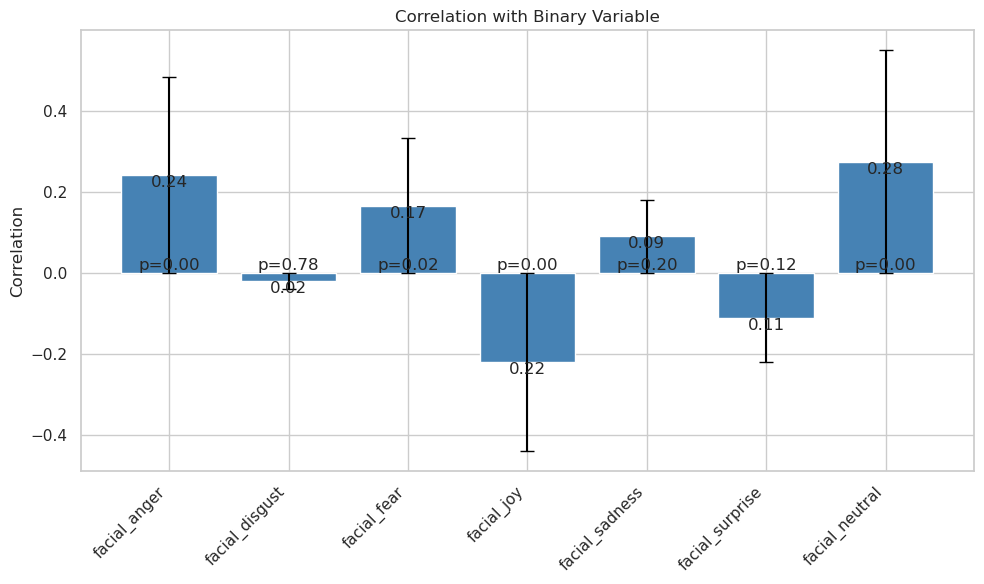

[('facial_anger', 0.24200327091066787, 0.0005555142327478556),
 ('facial_disgust', -0.020070810361340712, 0.7778718981353054),
 ('facial_fear', 0.16710824701522545, 0.018024742971261585),
 ('facial_joy', -0.21914234789819903, 0.0018226822442208204),
 ('facial_sadness', 0.09066141046516372, 0.201693928158671),
 ('facial_surprise', -0.10988543663749273, 0.12138928875012645),
 ('facial_neutral', 0.27520486142880946, 8.012722163015549e-05)]

In [360]:
get_correlations_with_binary(df_merged, 'len', ['facial_anger','facial_disgust','facial_fear','facial_joy','facial_sadness','facial_surprise','facial_neutral'],corr_func=spearmanr)

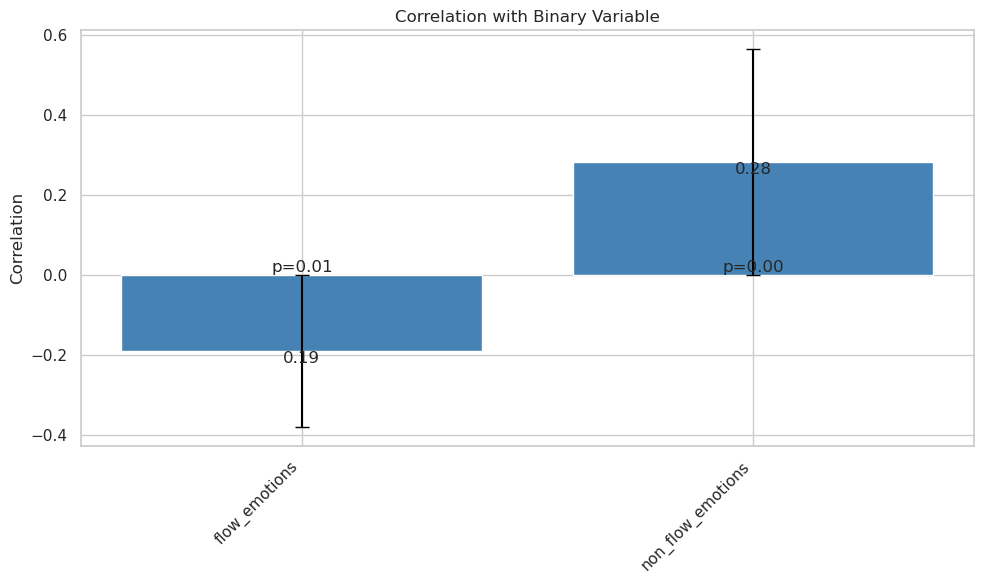

[('flow_emotions', -0.18959265482584847, 0.007169421441709946),
 ('non_flow_emotions', 0.2825139065323694, 5.052507569877522e-05)]

In [361]:
flow_emotions = ['facial_joy', 'facial_fear', 'facial_surprise']
non_flow =['facial_neutral', 'facial_sadness', 'facial_anger']
df_merged_cleaned = df_merged.drop(['segment_id', 'start', 'end', 'negative'], axis=1)
df_merged_cleaned=df_merged_cleaned.dropna(axis=0)
df_merged_cleaned
df_merged_cleaned['flow_emotions'] = df_merged_cleaned[flow_emotions].mean(axis=1)
df_merged_cleaned['non_flow_emotions'] = df_merged_cleaned[non_flow].mean(axis=1)
get_correlations_with_binary(df_merged_cleaned, 'len', ['flow_emotions', 'non_flow_emotions'],corr_func=spearmanr)